In [1]:
import os
import sys
# 如果当前代码文件运行测试需要加入修改路径，避免出现后导包问题
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.join(BASE_DIR))

PYSPARK_PYTHON = "/miniconda2/envs/reco_sys/bin/python"
# 当存在多个版本时，不指定很可能会导致出错
os.environ["PYSPARK_PYTHON"] = PYSPARK_PYTHON
os.environ["PYSPARK_DRIVER_PYTHON"] = PYSPARK_PYTHON

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from offline import SparkSessionBase

class CtrLogisticRegression(SparkSessionBase):

    SPARK_APP_NAME = "ctrLogisticRegression"
    ENABLE_HIVE_SUPPORT = True

    def __init__(self):

        self.spark = self._create_spark_hbase()

ctr = CtrLogisticRegression()

In [2]:
# 2、读取用户点击行为表，与用户画像和文章画像，构造训练样本
ctr.spark.sql('use profile')
news_article_basic = ctr.spark.sql("select user_id, article_id, channel_id, clicked from user_article_basic")

In [3]:
news_article_basic.show()

+-------------------+----------+----------+-------+
|            user_id|article_id|channel_id|clicked|
+-------------------+----------+----------+-------+
|1105045287866466304|     14225|         0|  false|
|1106476833370537984|     14208|         0|  false|
|1111189494544990208|     19322|         0|  false|
|1111524501104885760|     44161|         0|  false|
|1112727762809913344|     18172|        18|   true|
|                  1|     44386|        18|   true|
|                  1|     44696|         0|  false|
|                 10|     43907|         0|  false|
|1106473203766657024|     16005|         0|  false|
|1108264901190615040|     15196|         0|  false|
|                 23|     44739|        18|   true|
|                 33|     13570|         0|  false|
|                  1|     17632|         0|  false|
|1106473203766657024|     17665|         0|  false|
|1111189494544990208|     44368|         0|  false|
|                 10|     44368|         0|  false|
|11050938831

In [4]:
# 获取用户画像的数据
user_profile_hbase = ctr.spark.sql(
    "select user_id, information.birthday, information.gender, article_partial, env from user_profile_hbase")
user_profile_hbase = user_profile_hbase.drop('env')

In [7]:
user_profile_hbase.show()

+--------------------+--------+------+--------------------+
|             user_id|birthday|gender|     article_partial|
+--------------------+--------+------+--------------------+
|              user:1|     0.0|  null|Map(18:Animal -> ...|
|             user:10|     0.0|  null|Map(18:tp2 -> 0.1...|
|             user:11|     0.0|  null|               Map()|
|user:110249052282...|     0.0|  null|               Map()|
|user:110256196274...|     0.0|  null|               Map()|
|user:110319567345...|     0.0|  null|Map(18:Animal -> ...|
|user:110504528786...|     0.0|  null|Map(18:text -> 0....|
|user:110509388310...|     0.0|  null|Map(18:赋值 -> 0.16...|
|user:110510518565...|     0.0|  null|Map(18:SHOldboySt...|
|user:110639618314...|     0.0|  null|Map(18:tp2 -> 0.1...|
|user:110647320376...|     0.0|  null|Map(18:text -> 0....|
|user:110647683337...|     0.0|  null|Map(18:text -> 1....|
|user:110826490119...|    null|  null|Map(18:text -> 0....|
|user:111105316462...|     0.0|  null|  

In [8]:
# 对用户ID做处理
def get_user_id(row):
    return int(row.user_id.split(':')[1]), row.birthday, row.gender, row.article_partial

user_profile_hbase = user_profile_hbase.rdd.map(get_user_id)

In [9]:
# 对于其中toDF存在一些列没办法确定类型，手动指定DataFrame列的类型
_schema = StructType([
    StructField('user_id', LongType()),
    StructField('birthday', DoubleType()),
    StructField('gender', BooleanType()),
    StructField('article_partial', MapType(StringType(), DoubleType()))
])

user_profile_hbase = ctr.spark.createDataFrame(user_profile_hbase, schema=_schema)

In [10]:
user_profile_hbase.show()

+-------------------+--------+------+--------------------+
|            user_id|birthday|gender|     article_partial|
+-------------------+--------+------+--------------------+
|                  1|     0.0|  null|Map(18:Animal -> ...|
|                 10|     0.0|  null|Map(18:tp2 -> 0.1...|
|                 11|     0.0|  null|               Map()|
|1102490522829717504|     0.0|  null|               Map()|
|1102561962748805120|     0.0|  null|               Map()|
|1103195673450250240|     0.0|  null|Map(18:Animal -> ...|
|1105045287866466304|     0.0|  null|Map(18:text -> 0....|
|1105093883106164736|     0.0|  null|Map(18:赋值 -> 0.16...|
|1105105185656537088|     0.0|  null|Map(18:SHOldboySt...|
|1106396183141548032|     0.0|  null|Map(18:tp2 -> 0.1...|
|1106473203766657024|     0.0|  null|Map(18:text -> 0....|
|1106476833370537984|     0.0|  null|Map(18:text -> 1....|
|1108264901190615040|    null|  null|Map(18:text -> 0....|
|1111053164624216064|     0.0|  null|               Map(

In [11]:
# 合并用户点击行为表与用户画像表，并进行相应的删除无用特征
train = news_article_basic.join(user_profile_hbase, on=['user_id'], how='left').drop('birthday').drop('channel_id').drop('gender')


In [12]:
train.show()

+-------------------+----------+-------+--------------------+
|            user_id|article_id|clicked|     article_partial|
+-------------------+----------+-------+--------------------+
|1106473203766657024|     16005|  false|Map(18:text -> 0....|
|1106473203766657024|     17665|  false|Map(18:text -> 0....|
|1106473203766657024|     44664|  false|Map(18:text -> 0....|
|1106473203766657024|     44386|  false|Map(18:text -> 0....|
|1106473203766657024|     13778|  false|Map(18:text -> 0....|
|1106473203766657024|     13039|  false|Map(18:text -> 0....|
|1106473203766657024|     13648|  false|Map(18:text -> 0....|
|1106473203766657024|     17304|  false|Map(18:text -> 0....|
|1106473203766657024|     19233|  false|Map(18:text -> 0....|
|1106473203766657024|     44466|  false|Map(18:text -> 0....|
|1106473203766657024|     18795|  false|Map(18:text -> 0....|
|1106473203766657024|    134812|  false|Map(18:text -> 0....|
|1106473203766657024|     13357|  false|Map(18:text -> 0....|
|1106473

In [13]:
# 合并文章的向量以及文章的权重特征，文章所属的真正频道ID
ctr.spark.sql('use article')
article_vector = ctr.spark.sql("select * from article_vector")

In [14]:
train_user_article = train.join(article_vector, on=['article_id'], how='left')

In [15]:
train_user_article.show()

+-------------------+-------------------+-------+--------------------+----------+--------------------+
|         article_id|            user_id|clicked|     article_partial|channel_id|       articlevector|
+-------------------+-------------------+-------+--------------------+----------+--------------------+
|              13401|                 10|  false|Map(18:tp2 -> 0.1...|        18|[0.06157120217893...|
|              13401|1106396183141548032|  false|Map(18:tp2 -> 0.1...|        18|[0.06157120217893...|
|              14805|1106473203766657024|  false|Map(18:text -> 0....|        18|[0.11028526511434...|
|              14805|1103195673450250240|  false|Map(18:Animal -> ...|        18|[0.11028526511434...|
|              14805|1105045287866466304|  false|Map(18:text -> 0....|        18|[0.11028526511434...|
|              14805|1111524501104885760|  false|Map(18:text -> 0....|        18|[0.11028526511434...|
|              14805|1105105185656537088|  false|Map(18:SHOldboySt...|   

In [16]:
# 读取文章画像
article_profile = ctr.spark.sql("select article_id, keywords from article_profile")

def get_article_weights(row):
    
    try:
        weights = sorted(row.keywords.values())[:10]
    except Exception as e:
        weights = [0.0] * 10
    
    return row.article_id, weights

article_profile = article_profile.rdd.map(get_article_weights).toDF(['article_id', 'article_weights'])

In [17]:
article_profile.show()

+----------+--------------------+
|article_id|     article_weights|
+----------+--------------------+
|        26|[0.19827163395829...|
|        29|[0.26031398249056...|
|       474|[0.49818598558926...|
|       964|[0.42194661121527...|
|      1677|[0.19827339246090...|
|      1697|[0.25105539265038...|
|      1806|[0.18449119772340...|
|      1950|[0.33331407122173...|
|      2040|[0.38583431341698...|
|      2214|[0.43761156267670...|
|      2250|[0.46477621366740...|
|      2453|[0.50514620188273...|
|      2509|[0.15138306650944...|
|      2529|[0.11634963900866...|
|      2927|[0.28513034617795...|
|      3091|[0.23478830492918...|
|      3506|[0.22844780420769...|
|      3764|[0.27265314149033...|
|      4590|[0.40296288036812...|
|      4823|[0.21729897161021...|
+----------+--------------------+
only showing top 20 rows



In [18]:
# 合并文章权重
train_user_article = train_user_article.join(article_profile, on=['article_id'], how='left')

In [20]:
# 保留了用户的每个频道的关键词权重，找到用户对应操作文章的所属频道的关键词权重
train_user_article = train_user_article.dropna()

In [21]:
train_user_article.show()

+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|article_id|            user_id|clicked|     article_partial|channel_id|       articlevector|     article_weights|
+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|     13401|                 10|  false|Map(18:tp2 -> 0.1...|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|1106396183141548032|  false|Map(18:tp2 -> 0.1...|        18|[0.06157120217893...|[0.08196639249252...|
|     14805|1106473203766657024|  false|Map(18:text -> 0....|        18|[0.11028526511434...|[0.15069781969741...|
|     14805|1103195673450250240|  false|Map(18:Animal -> ...|        18|[0.11028526511434...|[0.15069781969741...|
|     14805|1105045287866466304|  false|Map(18:text -> 0....|        18|[0.11028526511434...|[0.15069781969741...|
|     14805|1111524501104885760|  false|Map(18:text -> 0....|        18|[0.11028

In [22]:
train_user_article

DataFrame[article_id: bigint, user_id: bigint, clicked: boolean, article_partial: map<string,double>, channel_id: int, articlevector: array<double>, article_weights: array<double>]

In [26]:
from pyspark.ml.linalg import Vectors
columns = ['article_id', 'user_id', 'channel_id', 'articlevector', 'user_weights', 'article_weights', 'clicked']
def get_user_weights(row):

    from pyspark.ml.linalg import Vectors
    try:
        # map对象的存储形式：channel_id: key_words --->weights
        user_weights = sorted([row.article_partial[key] for key in row.article_partial.keys() 
                               if key.split(':')[0] == str(row.channel_id)])[:10]
    except Exception:
        user_weights = [0.0] * 10
    # 将权重向量转换成Vector对象，方便后面模型处理
    return row.article_id, row.user_id, row.channel_id, Vectors.dense(row.articlevector), Vectors.dense(user_weights), Vectors.dense(row.article_weights), int(row.clicked)

train_vector = train_user_article.rdd.map(get_user_weights).toDF(columns)


In [27]:
# 收集所有特征到一个features列
train_res = VectorAssembler().setInputCols(columns[2:6]).setOutputCol('features').transform(train_vector)

In [28]:
train_res.show()

+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+--------------------+
|article_id|            user_id|channel_id|       articlevector|        user_weights|     article_weights|clicked|            features|
+----------+-------------------+----------+--------------------+--------------------+--------------------+-------+--------------------+
|     13401|                 10|        18|[0.06157120217893...|[0.16021155576912...|[0.08196639249252...|      0|[18.0,0.061571202...|
|     13401|1106396183141548032|        18|[0.06157120217893...|[0.16147375544143...|[0.08196639249252...|      0|[18.0,0.061571202...|
|     14805|1106473203766657024|        18|[0.11028526511434...|[0.16147375544143...|[0.15069781969741...|      0|[18.0,0.110285265...|
|     14805|1103195673450250240|        18|[0.11028526511434...|[0.16034784031666...|[0.15069781969741...|      0|[18.0,0.110285265...|
|     14805|1105045287866466304|        18|[0.11

In [29]:
train_res

DataFrame[article_id: bigint, user_id: bigint, channel_id: bigint, articlevector: vector, user_weights: vector, article_weights: vector, clicked: bigint, features: vector]

In [30]:
lr = LogisticRegression()
# 时间较长，可直接使用现成的以训练好的模型数据
# model = lr.setLabelCol("clicked").setFeaturesCol("features").fit(train_res)
# model.write().overwrite().save("hdfs://hadoop-master:9000/headlines/models/LR.obj")

In [31]:
online_model = LogisticRegressionModel.load("hdfs://hadoop-master:9000/headlines/models/LR.obj")

In [74]:
res = online_model.transform(train_res)

In [75]:
res_transfrom = res.select(['clicked', 'probability', 'prediction'])

In [76]:
res_transfrom.show(truncate=False)

+-------+----------------------------------------+----------+
|clicked|probability                             |prediction|
+-------+----------------------------------------+----------+
|0      |[0.8945788722833979,0.10542112771660195]|0.0       |
|0      |[0.8945803501853042,0.10541964981469573]|0.0       |
|0      |[0.8938062323124492,0.10619376768755093]|0.0       |
|0      |[0.8938049054546267,0.10619509454537333]|0.0       |
|0      |[0.8938055593529223,0.10619444064707778]|0.0       |
|0      |[0.893808753182054,0.10619124681794594] |0.0       |
|0      |[0.8938057257674243,0.10619427423257569]|0.0       |
|0      |[0.8938045853559466,0.10619541464405334]|0.0       |
|0      |[0.8938047448463091,0.10619525515369098]|0.0       |
|0      |[0.893809722810283,0.10619027718971703] |0.0       |
|1      |[0.8938045853559466,0.10619541464405334]|0.0       |
|0      |[0.8938062323124492,0.10619376768755093]|0.0       |
|0      |[0.8938062323124492,0.10619376768755093]|0.0       |
|0      

In [77]:
def get_probility(row):
    # 都转换成浮点类型，计算auc值时对数据要求都是浮点型
    return float(row.clicked), float(row.probability[1]) 

# 获取文章点击的概率
score_label = res_transfrom.rdd.map(get_probility).toDF(['clicked', 'probability'])

In [78]:
# 点击率都较低
score_label.show()

+-------+-------------------+
|clicked|        probability|
+-------+-------------------+
|    0.0|0.10542112771660195|
|    0.0|0.10541964981469573|
|    0.0|0.10619376768755093|
|    0.0|0.10619509454537333|
|    0.0|0.10619444064707778|
|    0.0|0.10619124681794594|
|    0.0|0.10619427423257569|
|    0.0|0.10619541464405334|
|    0.0|0.10619525515369098|
|    0.0|0.10619027718971703|
|    1.0|0.10619541464405334|
|    0.0|0.10619376768755093|
|    0.0|0.10619376768755093|
|    0.0|0.10619509454537333|
|    0.0|0.10619541464405334|
|    0.0|0.10619289812848465|
|    0.0|0.10619143609726191|
|    0.0|  0.105360488620998|
|    0.0|0.10535917096196065|
|    0.0|0.10613881081498276|
+-------+-------------------+
only showing top 20 rows



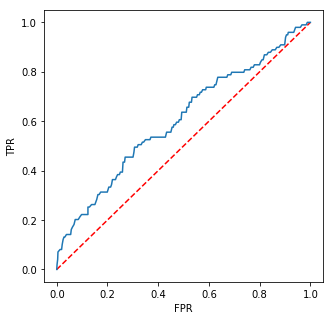

In [79]:
# 绘制ROC曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [86]:
def vector_to_double(row):
    return float(row.probability[1]), float(row.clicked)

# BinaryClassificationMetrics中传入的参数要求是：an RDD of (score, label) pairs
score_label = res_transfrom.select(["probability", "clicked"]).rdd.map(vector_to_double)

In [87]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# 交给BinaryClassificationMetrics计算的数据必须是RDD
roc = BinaryClassificationMetrics(score_label)
roc.areaUnderROC

0.6042585762156165

In [82]:
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

In [83]:
# 先转化成数组
arr = np.array(score_label.collect())

In [84]:
# 再计算准确率
accuracy_score(arr[:, 0], arr[:, 1].round())

0.8943436499466382

In [85]:
# 计算auc值
roc_auc_score(arr[:, 0], arr[:, 1])

0.6042585762156168

In [88]:
# 用户特征的构建存储
# 构造样本
ctr.spark.sql("use profile")

user_profile_hbase = ctr.spark.sql(
    "select user_id, information.birthday, information.gender, article_partial, env from user_profile_hbase")

# 特征工程处理
# 抛弃获取值少的特征
user_profile_hbase = user_profile_hbase.drop('env', 'birthday', 'gender')

def get_user_id(row):
    return int(row.user_id.split(":")[1]), row.article_partial

user_profile_hbase_temp = user_profile_hbase.rdd.map(get_user_id)

from pyspark.sql.types import *

_schema = StructType([
    StructField("user_id", LongType()),
    StructField("weights", MapType(StringType(), DoubleType()))
])

user_profile_hbase_schema = ctr.spark.createDataFrame(user_profile_hbase_temp, schema=_schema)

In [89]:
user_profile_hbase_schema.show()

+-------------------+--------------------+
|            user_id|             weights|
+-------------------+--------------------+
|                  1|Map(18:Animal -> ...|
|                 10|Map(18:tp2 -> 0.1...|
|1103195673450250240|Map(18:Animal -> ...|
|1105045287866466304|Map(18:text -> 0....|
|1105093883106164736|Map(18:赋值 -> 0.16...|
|1105105185656537088|Map(18:SHOldboySt...|
|1106396183141548032|Map(18:tp2 -> 0.1...|
|1106473203766657024|Map(18:text -> 0....|
|1106476833370537984|Map(18:text -> 1....|
|1108264901190615040|Map(18:text -> 0....|
|1111189494544990208|Map(18:text -> 0....|
|1111524501104885760|Map(18:text -> 0....|
|1112727762809913344|Map(18:text -> 0....|
|1113053603926376448|Map(18:ssword -> ...|
|1113244157343694848|Map(18:text -> 0....|
|                  2|Map(18:obj3 -> 0....|
|                 23|Map(18:结构化 -> 0.1...|
|                 33|Map(18:text -> 0....|
|                 38|Map(18:结构化 -> 0.1...|
|                  4|Map(13:ldquo -> 0...|
+----------

In [90]:
def feature_process(row):
    
    channel_weights = []
    for i in range(1, 26):
        try:
            w = sorted([row.weights[key] for key in row.weights.keys() if key.split(':')[0] == str(i)])[:10]
            channel_weights.append(w)
        except:
            channel_weights.append([0.0] * 10)
    return row.user_id, channel_weights

res = user_profile_hbase_schema.rdd.map(feature_process).collect()

In [91]:
res

[(1,
  [[],
   [],
   [],
   [],
   [],
   [],
   [1.1354814310844472],
   [],
   [],
   [],
   [],
   [],
   [1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472,
    1.1354814310844472],
   [],
   [],
   [],
   [],
   [0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806,
    0.16007622004474806],
   [],
   [],
   [],
   [],
   [],
   [],
   []]),
 (10,
  [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0.1602115557691254,
    0

In [93]:
# 存储用户25个频道的权重数据到Hbase当中
# import happybase
# pool = happybase.ConnectionPool(size=10, host='hadoop-master', port=9090)
# with pool.connection() as conn:
#     ctr_feature_user = conn.table('ctr_feature_user')
#     with ctr_feature_user.batch(transaction=True) as b:
#         for i in range(len(res)):
#             # user_id：res[i][0]
#             # feature：res[i][1]
#             for j in range(25):
#                 b.put(str(res[i][0]).encode(), {
#                     'channel:{}'.format(j+1).encode(): str(res[i][1][j]).encode()
#                 })
#     conn.close() 

In [94]:
# 文章特征中心
ctr.spark.sql("use article")
article_profile = ctr.spark.sql("select * from article_profile")
def article_profile_to_feature(row):
    try:
        weights = sorted(row.keywords.values())[:10]
    except Exception as e:
        weights = [0.0] * 10
    return row.article_id, row.channel_id, weights
article_profile = article_profile.rdd.map(article_profile_to_feature).toDF(['article_id', 'channel_id', 'weights'])

article_vector = ctr.spark.sql("select * from article_vector")
article_feature = article_profile.join(article_vector, on=['article_id'], how='inner')
def feature_to_vector(row):
    from pyspark.ml.linalg import Vectors
    return row.article_id, row.channel_id, Vectors.dense(row.weights), Vectors.dense(row.articlevector)
article_feature = article_feature.rdd.map(feature_to_vector).toDF(['article_id', 'channel_id', 'weights', 'articlevector'])

# 保存特征数据
cols2 = ['article_id', 'channel_id', 'weights', 'articlevector']
# 做特征的指定指定合并
article_feature_two = VectorAssembler().setInputCols(cols2[1:4]).setOutputCol("features").transform(article_feature)


In [95]:
article_feature_two.show()

+----------+----------+--------------------+--------------------+--------------------+
|article_id|channel_id|             weights|       articlevector|            features|
+----------+----------+--------------------+--------------------+--------------------+
|        26|        17|[0.19827163395829...|[0.02069368539384...|[17.0,0.198271633...|
|        29|        17|[0.26031398249056...|[-0.1446092289546...|[17.0,0.260313982...|
|       474|        17|[0.49818598558926...|[0.17293323921293...|[17.0,0.498185985...|
|      1677|        17|[0.19827339246090...|[-0.1303829028565...|[17.0,0.198273392...|
|      1697|         6|[0.25105539265038...|[0.05229978313861...|[6.0,0.2510553926...|
|      1806|        17|[0.18449119772340...|[0.02166337053188...|[17.0,0.184491197...|
|      1950|        17|[0.33331407122173...|[-0.3318378543653...|[17.0,0.333314071...|
|      2040|        17|[0.38583431341698...|[-0.0164312324191...|[17.0,0.385834313...|
|      2250|         6|[0.46477621366740...

In [96]:
def save_article_feature_to_hbase(partition):
    import happybase
    pool = happybase.ConnectionPool(size=10, host='hadoop-master')
    with pool.connection() as conn:
        table = conn.table('ctr_feature_article')
        for row in partition:
            table.put('{}'.format(row.article_id).encode(),
                     {'article:{}'.format(row.article_id).encode(): str(row.features).encode()})

# article_feature_two.foreachPartition(save_article_feature_to_hbase)